<a href="https://colab.research.google.com/github/yayayida/Stockholm-Traffic-Flow-Modeling/blob/main/MainModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Python Environment


In [ ]:
!pip install haversine

In [ ]:
!python -V
import os
if 'CONDA_DEFAULT_ENV' in os.environ:
    print("Conda ENV - ", os.environ['CONDA_DEFAULT_ENV'])
else:
    print("Conda ENV - Not set (might not be in a conda environment or variable not exported)")

Python 3.12.12
Conda ENV - Not set (might not be in a conda environment or variable not exported)


## Python Libraries


In [ ]:
import Landuse
#from Demand import Demand
import Network
import Assignment
from Visualization import Visualize
from Effect import Effect
import numpy as np
import pandas as pd

## Variable setting

In [ ]:
######### VARIABLES ############
fuel_cost = 12      # fuel cost 12 sek/liter
fuel_con = 0.085    # fuel consumption is 0.085 l/km
cost_km = fuel_cost * fuel_con
carparking = 10      # Cost of Parking
transitprice = 30   # Cost of Transit
penalty_intra_car = 30

## Parameter setting

In [ ]:
######### PARAMETERS ############
alpha = 0.5        # constant for car mode
beta_car = -0.08  # parameter for car travel time
gamma_car = -0.05   # parameter for car travel cost
beta_inv = -0.05    # parameter for transit in-vehile travel time
beta_wait = -0.08    # parameter for transit total waiting time
gamma_pt = -0.05  # parameter for transit ticket price
alpha_slow = 0.1  #parameter for slow mode
phi_dist = -0.5    # parameter for slow mode time
mu = 0.5            # Logsum weight
theta = 1           # parameter for destination choice
param = [alpha, beta_car, gamma_car, beta_inv, beta_wait, gamma_pt, alpha_slow, phi_dist, mu, theta] # to pass the parameter value to demand function as a list
vot_car = beta_car/gamma_car        # value of time for car
vot_in = beta_inv/gamma_pt         # value of in-vehile travel time for transit
vot_wait = beta_wait/gamma_pt      # value of total waiting time for transit
constant = 0.2      # alternative specific constant for owning a car
income = 0.003      # parameter for income
dummy = -0.5        # dummy for residency in the inner city
param_carown = [constant, income, dummy] # to pass the parameter value to landuse function as a list

## Import data

In [ ]:
# Load landuse and zone information
landuse, zones = Landuse.get_landuse_and_zones(param_carown)

# Origin and Destination dictionary
origin      = dict(zip(landuse.area, landuse.index))
destination = origin.copy()

# Create Graph network for car and transit
G_car = Network.RoadNetwork(zones.transpose())
G_pt = Network.TransitNetwork(zones.transpose())

## Initialize the network

In [ ]:
# Initialize the network
demand = np.ones((len(landuse), len(landuse)))
# Now add intra-zonal links
G_car, G_pt = Assignment.add_intra_zonal_links(
    G_car,
    G_pt,
    zones=zones,
    landuse=landuse,
    vot_car=vot_car,
    vot_pt=vot_in,
    cost_km=cost_km,
    transitprice=transitprice,
    penalty_intra_car=penalty_intra_car
)

# Run assignment
G_start_car = Assignment.RouteAssignment(np.asarray(demand), G_car, origin, destination,vot_car,cost_km,penalty_intra_car)
G_start_pt = Assignment.TransitAssignment(np.asarray(demand), G_pt, origin, destination,vot_in,vot_wait)
car_time_0, car_cost_0, dist = Assignment.Skim_car(G_start_car, origin, destination, penalty_intra_car)
invt, waitt = Assignment.Skim_pt(G_start_pt, origin, destination)

ROUTE ASSIGNMENT
---------------------------------------------------------------------------------------------
  ITR    Total System Travel Time    Shortest Path Travel Times    Relgap    Changes in in volume
-----  --------------------------  ----------------------------  --------  ----------------------
    1                     1934.15                       1934.15         0                       0
---------------------------------------------------------------------------------------------
assignment: k = 2 relgap = 0.000000, AEC = 0.000000


## Demand funtion example with fixed probability

In [ ]:
def Demand_fix (car_time, car_cost, car_park, inv_time, wait_time, pt_price, dist, parameter, pop, emp, own):

    # the following parameters will be used for utility functions
    alpha = parameter[0]
    beta_car = parameter[1]
    gamma_car = parameter[2]
    beta_inv = parameter[3]
    beta_wait = parameter[4]
    gamma_pt = parameter[5]
    phi_dist = parameter[6]
    mu = parameter[7]
    theta = parameter[8]

    pop = np.asmatrix(pop).transpose()
    own = np.asmatrix(own).transpose()
    emp = np.asmatrix(emp)

    # assuming a fixed probability
    Pcar = np.ones((len(pop), len(pop))) *(0.4/len(pop))
    Ppt  = np.ones((len(pop), len(pop)))  *(0.4/len(pop))
    Pslow= np.ones((len(pop), len(pop)))*(0.2/len(pop))

    # calculating the demand
    Vol_car  = np.multiply(pop,Pcar)
    Vol_pt   = np.multiply(pop,Ppt)
    Vol_slow = np.multiply(pop,Pslow)
    EU = 0

    return (Vol_car, Vol_pt, Vol_slow, EU)

## Equilibrium

In [ ]:
## Suggested Equilibrium cell (also based on the Project file)
# calculate demand
maxiter = 100       # maxium number of iterations in finding the equilibrium
maxdiff = 0.01      # or if the travel time converges to the point where difference in travel time between iterations is smaller than 0.01
car_time=car_time_0
car_cost=car_cost_0
for iter in range(maxiter):
    print("\n")
    car_time_old = car_time
    car_cost_old = car_cost

    # Here, you can change to your demand funtion
    v_car, v_pt, v_slow, EU = Demand_fix(car_time,
                         car_cost,
                         carparking,
                         invt,
                         waitt,
                         transitprice,
                         dist,
                         param,
                         np.array(landuse['pop']),
                         np.array(landuse['emp']),
                         np.array(landuse['car_ownership']))
    # assign the traffic based on the demand to get the new car time, cost, and distance
    print(f"the car demand to routeassignment: {np.sum(v_car)}")
    G_next_car = Assignment.RouteAssignment(np.asarray(v_car), G_car, origin, destination,vot_car,cost_km, penalty_intra_car)
    G_next_pt = Assignment.TransitAssignment(np.asarray(v_pt), G_pt, origin, destination,vot_in,vot_wait)
    car_time, car_cost, dist = Assignment.Skim_car(G_next_car, origin, destination, penalty_intra_car)

    # calculate car_time values with 0.2 share of new values (from assignemet.skim_car) and
    # 0.8 share of the old car time values
    car_time = car_time * 0.2 + car_time_old * 0.8
    car_cost = car_cost * 0.2 + car_cost_old * 0.8

    # define the average error (e.g. 0.2) for convergence, and if it is met, make (stop = 1)
    diff = (np.mean((np.abs(car_time-car_time_old))))
    print(f"Iteration: {iter}\tDifference in travel time:{diff}")
    if (diff < maxdiff) or (iter>=maxiter):
        break




the car demand to routeassignment: 320000.0
ROUTE ASSIGNMENT
---------------------------------------------------------------------------------------------
  ITR    Total System Travel Time    Shortest Path Travel Times     Relgap    Changes in in volume
-----  --------------------------  ----------------------------  ---------  ----------------------
    1                 1.20539e+07                   1.10732e+07  0.0885717                  295418
    2                 1.10793e+07                   1.08657e+07  0.0196656                  147600
    3                 1.10666e+07                   1.09081e+07  0.0145326                  127258
    4                 1.10623e+07                   1.09327e+07  0.0118518                  121914
    5                 1.10623e+07                   1.09333e+07  0.0117942                  121795
    6                 1.10622e+07                   1.09339e+07  0.0117368                  121676
    7                 1.10621e+07                  

## RESULT
The cells shows the result of the 4-step model.

In [ ]:
# output result in a table, you can specify what output might be useful
# Hint: what is the total number of trips?
pd.options.display.float_format = '{: ,.0f}'.format
from Effect import Effect
Effect(v_car, v_pt, v_slow, dist, carparking, transitprice, EU)

,VALUE
Car Trips,"320,000"
Car Mode Share (%),40.00%
Transit Trips,"320,000"
Transit Mode Share (%),40.00%
Slow Trips,"160,000"
Slow Mode Share (%),20.00%
Total trips,"800,000"
Distance Travelled (1000 km),"58,155"
Noise Cost (€),"4,710,580"
Waiting Time Cost (€),"581,553"


In [ ]:
# below the car flow and transit flow are plotted in seperate layer, you can activate/deactivate layers
Visualize(G_next_car, G_next_pt, zones, title="REULST FOR 4-STEP MODEL")

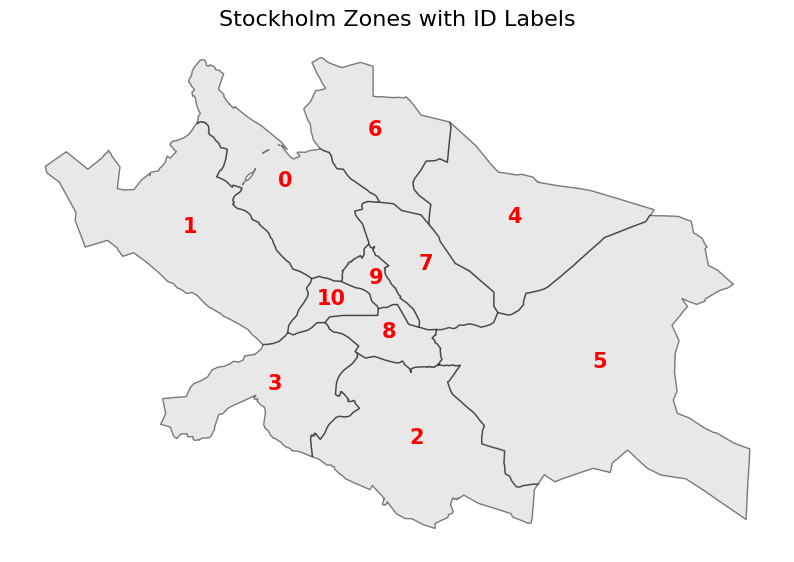

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

zones_gdf = gpd.read_file("zones.geojson")
fig, ax = plt.subplots(figsize=(10, 10))
zones_gdf.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.5)

for idx, row in zones_gdf.iterrows():
    centroid = row.geometry.centroid
    ax.annotate(text=str(idx),
                xy=(centroid.x, centroid.y),
                horizontalalignment='center',
                color='red',
                weight='bold',
                fontsize=15)

plt.title("Stockholm Zones with ID Labels", fontsize=16)
plt.axis('off')
plt.show()

# Nest Logit with car ownership model


In [ ]:
def Demand_nestlogit_ownership(car_time, car_cost, car_park, inv_time, wait_time, pt_price, dist, parameter, pop, emp, own):

    # 1. Parameters Setting
    alpha_car   = parameter[0]
    beta_car    = parameter[1]
    gamma_car   = parameter[2]
    beta_inv    = parameter[3]
    beta_wait   = parameter[4]
    gamma_pt    = parameter[5]
    alpha_slow  = parameter[6]
    phi_dist    = parameter[7]
    mu          = parameter[8]
    theta       = parameter[9]

    pop = np.asmatrix(pop).transpose()
    own = np.asmatrix(own).transpose()
    emp = np.asmatrix(emp)

    # Ensure all time, cost, and distance arrays are ndarrays
    car_time = np.asmatrix(car_time)
    car_cost = np.asmatrix(car_cost)
    inv_time = np.asmatrix(inv_time)
    wait_time = np.asmatrix(wait_time)
    dist = np.asmatrix(dist)

    # 2. Utility Functions for each mode and attractions
    # Car: V = alpha + beta*t + gamma*c
    Vcar  = parameter[0] + (parameter[1] * car_time) + (parameter[2] * (car_cost + car_park))
    # PT: V = beta*t_inv + beta*t_wait + gamma*c
    Vpt   = (parameter[3] * inv_time) + (parameter[4] * wait_time) + (parameter[5] * pt_price)
    # Slow: V = alpha_slow + phi*dist
    Vslow = parameter[6] + (parameter[7] * dist)
    # Attractions Vj:
    Vj  = parameter[9] * np.log(emp)

    # 3. CAR OWNERS
    # 3.1 Calculate Logsum (I) and P(m|j) - three modes
    exp_car = np.exp(Vcar / mu)
    exp_pt = np.exp(Vpt / mu)
    exp_slow = np.exp(Vslow / mu)
    denom_own = exp_car + exp_pt + exp_slow
    Lj_own = np.log(denom_own + 1e-10)

    Pcar_own = exp_car / denom_own
    Ppt_own = exp_pt / denom_own
    Pslow_own = exp_slow / denom_own

    # 3.2 Calculate Marginal Probability from i to j
    V_dest_own = Vj + (mu * Lj_own)
    exp_dest_own = np.exp(V_dest_own)
    sum_dest_own = np.sum(exp_dest_own, axis=1)
    Pj_own = exp_dest_own / sum_dest_own
    # p_sum_own = np.sum(Pj_own, axis = 1)
    # print("Result - Marginal Probability from i to j is:", Pj)
    # print("Check - Sum of Marginal Probability:", p_sum_own)

    # 3.3 Calculate Joint Probability
    Pcar_j_own = np.multiply(Pj_own, Pcar_own)
    Ppt_j_own  = np.multiply(Pj_own, Ppt_own)
    Pslow_j_own = np.multiply(Pj_own, Pslow_own)
    # pj_sum_own = np.sum(Pcar_j_own, axis=1) + np.sum(Ppt_j_own, axis=1) + np.sum(Pslow_j_own, axis=1)
    # print("Check - Sum of Joint Probability:", pj_sum_own)

    # 3.4 Calculate the Demand
    pop_own = np.multiply(pop, own)
    Vol_car_own = np.multiply(pop_own, Pcar_j_own)
    Vol_pt_own = np.multiply(pop_own, Ppt_j_own)
    Vol_slow_own = np.multiply(pop_own, Pslow_j_own)
    Vol_sum_own = np.sum(Vol_car_own) + np.sum(Vol_pt_own) + np.sum(Vol_slow_own)

    # 3.5 Calculate Expected Utility
    # EU_i = log(Σ_j exp(V_j + μ * I_j))
    EU_own = np.multiply(pop_own, np.log(sum_dest_own))

    # 4. NON-CAR OWNERS
    # 4.1 Calculate Logsum (I) and P(m|j) - two modes
    denom_nocar = exp_pt + exp_slow
    Ij_nocar = np.log(denom_nocar + 1e-10)

    Ppt_nocar = exp_pt / denom_nocar
    Pslow_nocar = exp_slow / denom_nocar

    # 4.2 Calculate Marginal Probability from i to j
    V_dest_nocar = Vj + (mu * Ij_nocar)
    exp_dest_nocar = np.exp(V_dest_nocar)
    sum_dest_nocar = np.sum(exp_dest_nocar, axis=1)
    Pj_nocar = exp_dest_nocar / sum_dest_nocar

    # 4.3 Calculate Joint Probability
    Ppt_j_nocar = np.multiply(Pj_nocar, Ppt_nocar)
    Pslow_j_nocar = np.multiply(Pj_nocar, Pslow_nocar)

    # 4.4 Calculate the Demand
    pop_nocar = np. multiply(pop, (1 - own))
    Vol_pt_nocar = np.multiply(pop_nocar, Ppt_j_nocar)
    Vol_slow_nocar = np.multiply(pop_nocar, Pslow_j_nocar)

    # 4.5 Calculate Expected Utility
    EU_nocar = np.multiply(pop_nocar, np. log(sum_dest_nocar))

    # 5. TOTAL Volume
    Vol_car = Vol_car_own
    Vol_pt = Vol_pt_own + Vol_pt_nocar
    Vol_slow = Vol_slow_own + Vol_slow_nocar
    EU = EU_own + EU_nocar
    print("Result - Volume of Car:", Vol_car.sum())
    print("Result - Volume of PT:", Vol_pt.sum())
    print("Result - Volume of Slow:", Vol_slow.sum())

    return Vol_car, Vol_pt, Vol_slow, EU

In [ ]:
# Settings: Max Iterations; Convergence Threshold; Smoothing Factors
maxiter = 100
maxdiff = 0.01
smoothing = 0.2
print("Start Iterations for Equilibrium:")

for iter in range(maxiter):
    car_time_old = car_time.copy()
    car_cost_old = car_cost.copy()

    # 1. Demand based on current travel time
    v_car, v_pt, v_slow, EU = Demand_nestlogit_ownership(
        car_time, car_cost, carparking, invt, waitt,
        transitprice, dist, param,
        np.array(landuse['pop']),
        np.array(landuse['emp']),
        np.array(landuse['car_ownership']))
    print(f"Total Car Demand: {np.sum(v_car):,.0f}")
    print(f"Total PT Demand: {np.sum(v_pt):,.0f}")
    print(f"Total Slow Demand: {np.sum(v_slow):,.0f}")

    # 2. Traffic Assignmnet
    G_next_car = Assignment.RouteAssignment(
        np.asarray(v_car), G_car, origin, destination,
        vot_car, cost_km, penalty_intra_car)
    G_next_pt = Assignment.TransitAssignment(
        np.asarray(v_pt), G_pt, origin, destination,
        vot_in, vot_wait)

    # 3. New Time and Cost
    car_time_new, car_cost_new, dist = Assignment.Skim_car(
        G_next_car, origin, destination, penalty_intra_car)

    # 4. MSA Smoothing
    car_time = car_time_new * smoothing + car_time_old * (1 - smoothing)
    car_cost = car_cost_new * smoothing + car_cost_old * (1 - smoothing)

    # 5. Convergence Signal
    diff = (np.mean((np.abs(car_time - car_time_old))))
    print(f"Iteration: {iter+1}\tDemand:{np.sum(v_car):.0f}, Difference in travel time:{diff:.4f}")
    if (diff < maxdiff) or (iter>=maxiter-1):
        print(f"\nConverged at iteration {iter+1}!")
        break

print(f"\nFinal Equilibrium Result:")
print(f"Car Trips: {np.sum(v_car):,.0f}")
print(f"PT Trips: {np.sum(v_pt):,.0f}")
print(f"Slow Trips: {np.sum(v_slow):,.0f}")
print(f"Expected Utility: {np.sum(EU):,.0f}")

Start Iterations for Equilibrium:
Result - Volume of Car: 359573.7999397784
Result - Volume of PT: 360725.1511450275
Result - Volume of Slow: 79701.0489151942
Total Car Demand: 359,574
Total PT Demand: 360,725
Total Slow Demand: 79,701
ROUTE ASSIGNMENT
---------------------------------------------------------------------------------------------
  ITR    Total System Travel Time    Shortest Path Travel Times    Relgap    Changes in in volume
-----  --------------------------  ----------------------------  --------  ----------------------
    1                  5.9187e+06                    5.9187e+06         0                       0
---------------------------------------------------------------------------------------------
assignment: k = 2 relgap = 0.000000, AEC = 0.000000
Iteration: 1	Demand:359574, Difference in travel time:2.0176
Result - Volume of Car: 376270.23357223213
Result - Volume of PT: 345990.12638880964
Result - Volume of Slow: 77739.64003895814
Total Car Demand: 376,27

In [ ]:
from Effect import Effect
Effect(v_car, v_pt, v_slow, dist, carparking, transitprice, EU)

,VALUE
Car Trips,"408,599"
Car Mode Share (%),51.07%
Transit Trips,"317,552"
Transit Mode Share (%),39.69%
Slow Trips,"73,848"
Slow Mode Share (%),9.23%
Total trips,"800,000"
Distance Travelled (1000 km),"71,152"
Noise Cost (€),"5,763,346"
Waiting Time Cost (€),"711,524"


In [ ]:
avg_car_ownership = np.mean(landuse['car_ownership'])
print(f"Average Car Ownership: {avg_car_ownership:.2%}")

Average Car Ownership: 73.60%


# Bandwidth Map

In [ ]:
Visualize(G_next_car, G_next_pt, zones, title="")

In [ ]:
# import importlib
# import Visualization
# importlib.reload(Visualization)
# from Visualization import Visualize
m = Visualize(G_next_car, G_next_pt, zones, title="Traffic Flows", show_text_threshold=10000)
m

# Social-Economic Demographics

## Population and Employment Distribution Map

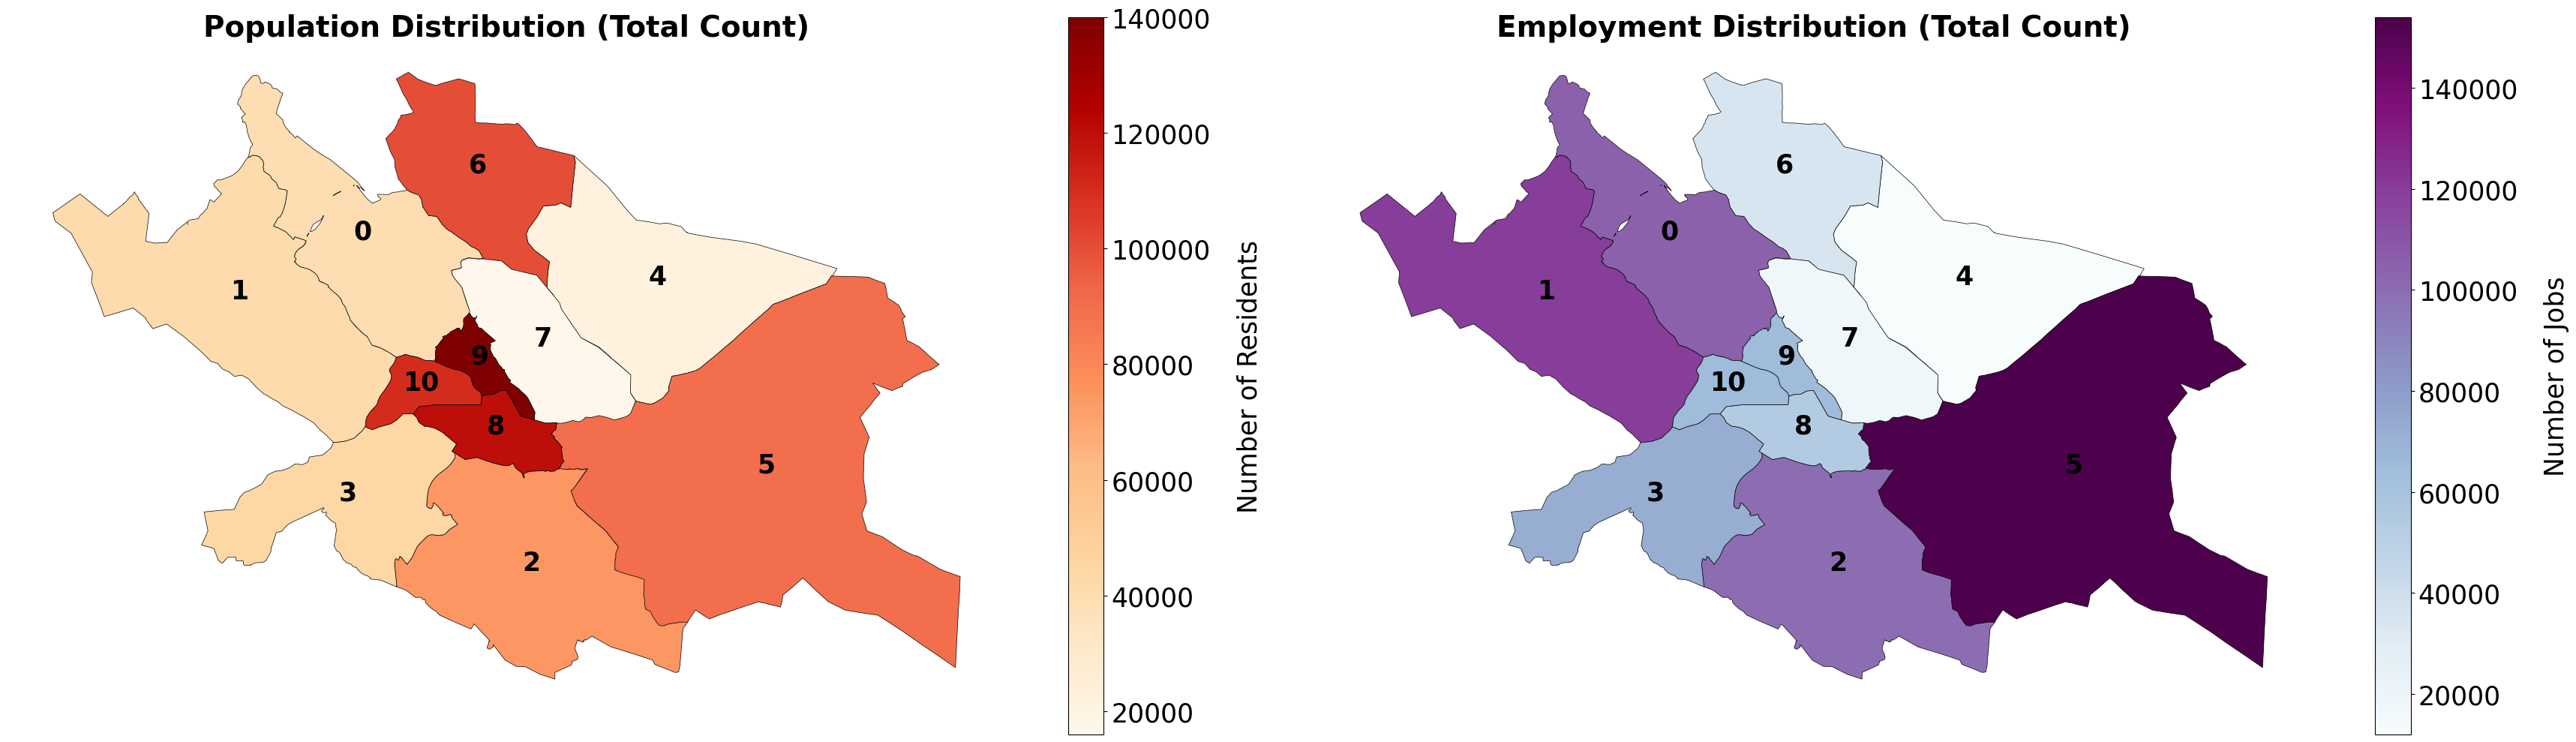

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

zones_gdf = gpd.read_file("zones.geojson")
landuse = pd.read_csv("landuse.csv", sep=";")

zones_gdf['pop'] = landuse['pop']
zones_gdf['emp'] = landuse['emp']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(35, 10))

zones_gdf.plot(column='pop',
               ax=ax1,
               legend=True,
               cmap='OrRd',
               edgecolor='black',
               linewidth=0.5,
               legend_kwds={'label': "Number of Residents"})
cbar1 = ax1.get_figure().get_axes()[2]
cbar1.set_ylabel("Number of Residents", fontsize=25, labelpad=25)
cbar1.tick_params(labelsize=25)
ax1.set_title('Population Distribution (Total Count)', fontsize=28, fontweight='bold')
ax1.axis('off')

for idx, row in zones_gdf.iterrows():
    ax1.annotate(text=str(idx),
                 xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                 ha='center', fontsize=25, color='black', weight='bold')

zones_gdf.plot(column='emp',
               ax=ax2,
               legend=True,
               cmap='BuPu',
               edgecolor='black',
               linewidth=0.5,
               legend_kwds={'label': "Number of Jobs"})
cbar2 = ax2.get_figure().get_axes()[3]
cbar2.set_ylabel("Number of Jobs", fontsize=25, labelpad=25)
cbar2.tick_params(labelsize=25)
ax2.set_title('Employment Distribution (Total Count)', fontsize=28, fontweight='bold')
ax2.axis('off')

for idx, row in zones_gdf.iterrows():
    ax2.annotate(text=str(idx),
                 xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                 ha='center', fontsize=25, color='black', weight='bold')

plt.tight_layout()
plt.show()

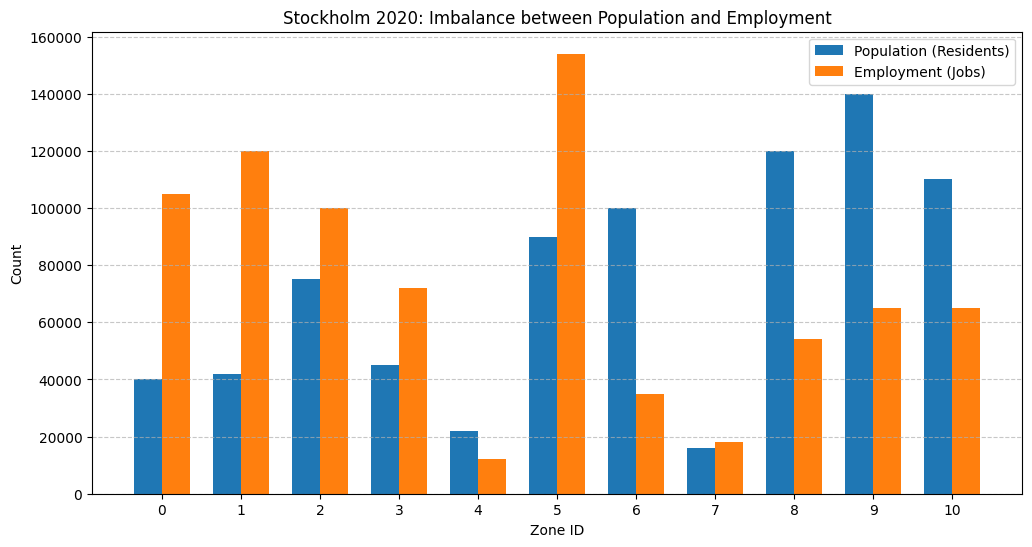

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 6))

zones = landuse.index
x = np.arange(len(zones))
width = 0.35

plt.bar(x - width/2, landuse['pop'], width, label='Population (Residents)')
plt.bar(x + width/2, landuse['emp'], width, label='Employment (Jobs)')

plt.xlabel('Zone ID')
plt.ylabel('Count')
plt.title('Stockholm 2020: Imbalance between Population and Employment')
plt.xticks(x, zones)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

## Income and Car Ownership Distribution Map

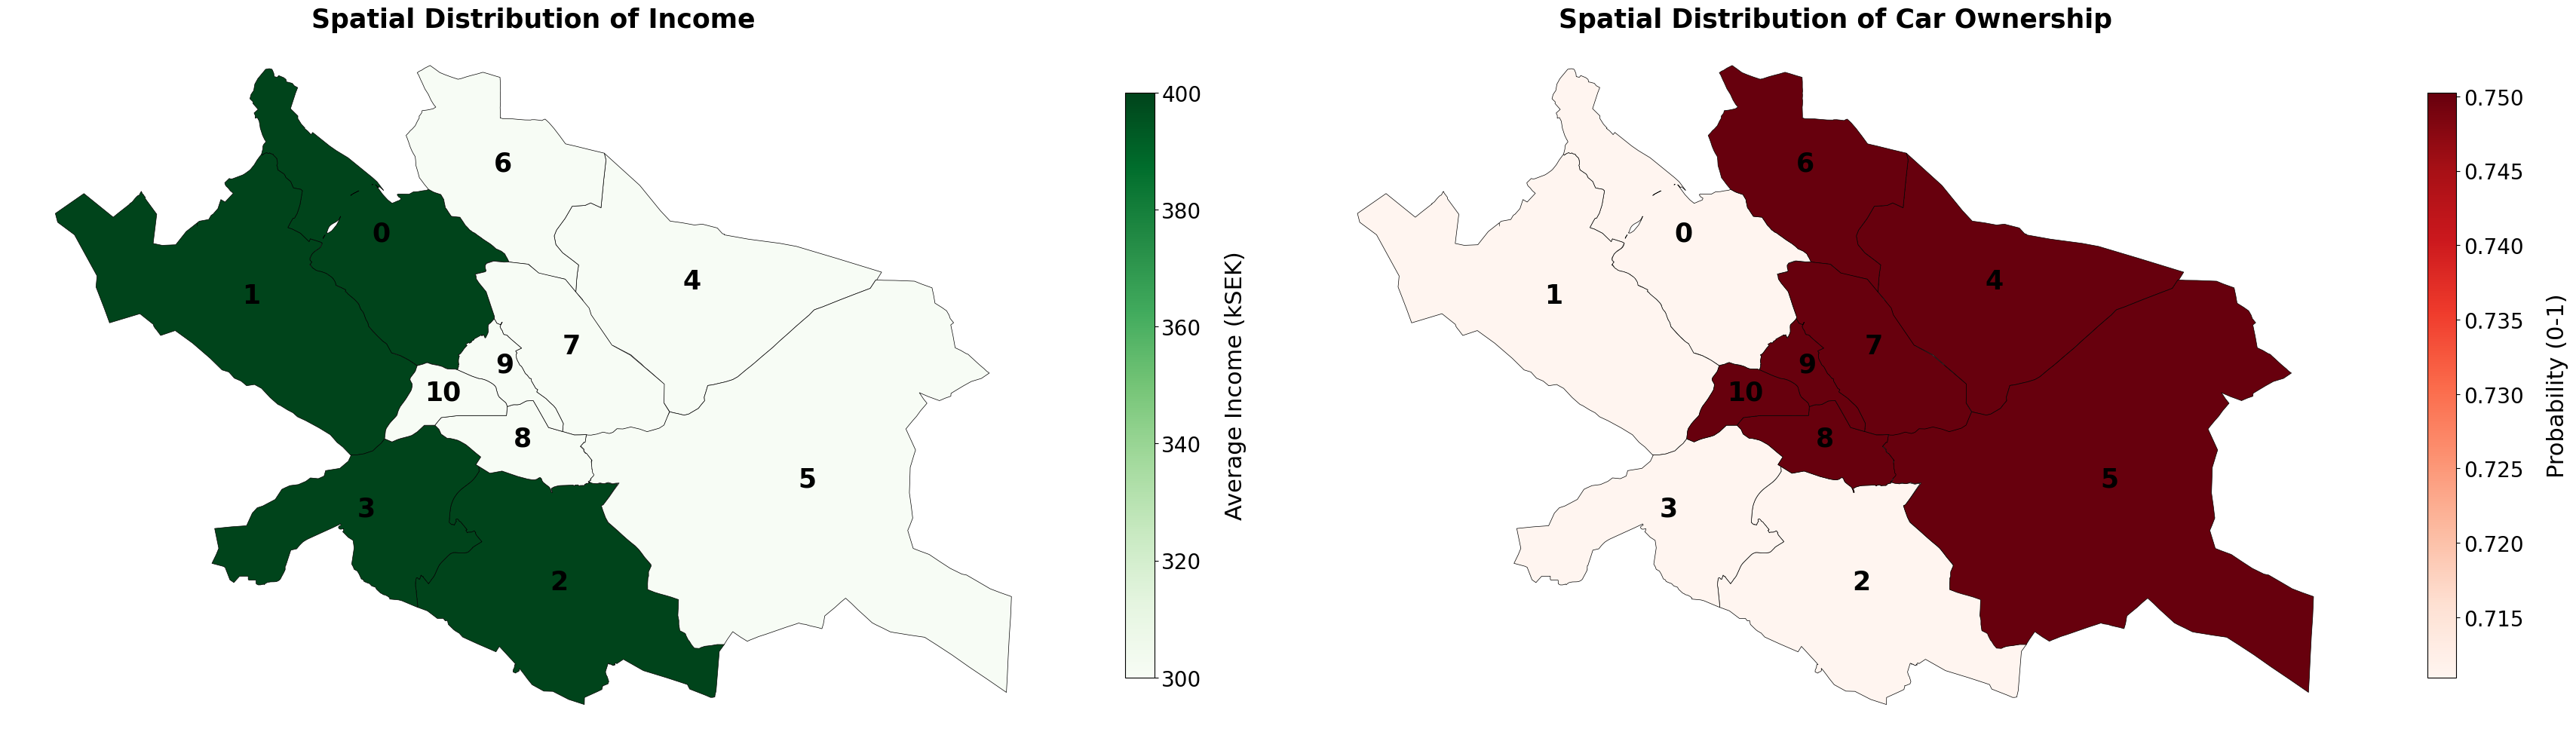

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

zones_gdf = gpd.read_file("zones.geojson")
zones_gdf['Income'] = landuse['inc']
zones_gdf['Car_Ownership'] = landuse['car_ownership']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(35, 10))

zones_gdf.plot(column='Income',
               ax=ax1,
               legend=True,
               cmap='Greens',
               edgecolor='black',
               linewidth=0.5,
               legend_kwds={
                   'label': "Average Yearly Income (kSEK)",
                   'orientation': "vertical",
                   'shrink': 0.8
               })

cbar1 = ax1.get_figure().get_axes()[2]
cbar1.set_ylabel("Average Income (kSEK)", fontsize=22, labelpad=22)
cbar1.tick_params(labelsize=20)
ax1.set_title('Spatial Distribution of Income', fontsize=25, fontweight='bold')
ax1.axis('off')

for idx, row in zones_gdf.iterrows():
    ax1.annotate(text=str(idx),
                 xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                 ha='center', fontsize=25, color='black', weight='bold')

zones_gdf.plot(column='Car_Ownership',
               ax=ax2,
               legend=True,
               cmap='Reds',
               edgecolor='black',
               linewidth=0.5,
               legend_kwds={
                   'label': "Car Ownership Probability",
                   'orientation': "vertical",
                   'shrink': 0.8
               })

cbar2 = ax2.get_figure().get_axes()[3]
cbar2.set_ylabel("Probability (0-1)", fontsize=22, labelpad=22)
cbar2.tick_params(labelsize=20)
ax2.set_title('Spatial Distribution of Car Ownership', fontsize=25, fontweight='bold')
ax2.axis('off')

for idx, row in zones_gdf.iterrows():
    ax2.annotate(text=str(idx),
                 xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                 ha='center', fontsize=25, color='black', weight='bold')

plt.tight_layout()
plt.show()